In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib notebook

In [2]:
xtrain = pd.read_csv("./ml_case_data/ml_case_training_data.csv")
ytrain = pd.read_csv("./ml_case_data/ml_case_training_output.csv")
nrows = xtrain.shape[0]
ncols = xtrain.shape[1]
xtrain.isnull().sum()/nrows

xtest = pd.read_csv("./ml_case_data/ml_case_test_data.csv")
trows = xtest.shape[0]
tcols = xtest.shape[1]
print nrows, ncols, trows, tcols
xtest.isnull().sum()/trows

joint = pd.concat(( xtrain, xtest ))
#drop columns with high NaN 
#xtrain.drop('campaign_disc_ele','date_first_activ', 'forecast_base_bill_ele', 'forecast_base_bill_year',
#            'forecast_bill_12m', 'forecast_cons', axis=1)
joint.drop(joint.columns[[2,9,12,13,14,15]], axis=1, inplace=True)
joint.isnull().sum()/nrows

16096 32 4024 32


id                          0.000000
activity_new                0.739252
channel_sales               0.327659
cons_12m                    0.000000
cons_gas_12m                0.000000
cons_last_month             0.000000
date_activ                  0.000000
date_end                    0.000124
date_modif_prod             0.012550
date_renewal                0.002734
forecast_cons_12m           0.000000
forecast_cons_year          0.000000
forecast_discount_energy    0.009319
forecast_meter_rent_12m     0.000000
forecast_price_energy_p1    0.009319
forecast_price_energy_p2    0.009319
forecast_price_pow_p1       0.009319
has_gas                     0.000000
imp_cons                    0.000000
margin_gross_pow_ele        0.000932
margin_net_pow_ele          0.000932
nb_prod_act                 0.000000
net_margin                  0.001118
num_years_antig             0.000000
origin_up                   0.007083
pow_max                     0.000249
dtype: float64

In [110]:
# historical data feature generation

#trend energy p1 drop, p2 drop, p3 raise
#power all raise
xhisttrain = pd.read_csv("./ml_case_data/ml_case_training_hist_data.csv")
xhisttest = pd.read_csv("./ml_case_data/ml_case_test_hist_data.csv")
print xhisttrain.shape, xhisttest.shape
nhisttrainrows = xhisttrain.shape[0]
#xhisttrain.isnull().sum()/nrows
print xhisttest.columns

xhisttrain.drop(xhisttrain.columns[[1]], axis=1, inplace=True)
xhtrain_agg = xhisttrain.groupby('id').mean()
xhtrain_agg.reset_index(inplace=True)
xhtrain_agg.fillna(0, inplace=True)
print xhtrain_agg.shape

xhisttest.drop(xhisttest.columns[[1]], axis=1, inplace=True)
xhtest_agg = xhisttest.groupby('id').mean()
xhtest_agg.reset_index(inplace=True)
xhtest_agg.fillna(0, inplace=True)
print xhtest_agg.shape

prices = pd.merge(xhtrain_agg,ytrain,on='id',how='inner')
print prices.shape

from sklearn import linear_model
model = linear_model.LogisticRegression()
x_use = prices.iloc[:,1:7]
y_use = prices.iloc[:,7]
x_use_array = x_use.values
y_use_array = y_use.values
scaler = MinMaxScaler(feature_range=(0,1))
lX = scaler.fit_transform(x_use_array)
model.fit(lX,y_use_array)
print model.score(lX,y_use_array)
print model.coef_

(193002, 8) (48236, 8)
Index([u'id', u'price_date', u'price_p1_var', u'price_p2_var', u'price_p3_var',
       u'price_p1_fix', u'price_p2_fix', u'price_p3_fix'],
      dtype='object')
(16096, 7)
(4024, 7)
(16096, 8)
0.900907057654
[[ 1.61243747 -0.65443556  0.46567639  0.25624593 -0.00928022  0.43053649]]


In [111]:
model.intercept_

logit = sm.Logit(y_use_array,lX)
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.326395
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                16096
Model:                          Logit   Df Residuals:                    16090
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 Sep 2017   Pseudo R-squ.:                -0.01025
Time:                        13:04:40   Log-Likelihood:                -5253.7
converged:                       True   LL-Null:                       -5200.4
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             2.9753      0.700      4.248      0.000         1.603     4.348
x2            -0.9046      0.

In [112]:
rfprice = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=0)
rfprice.fit(lX,y_use_array)
print rfprice.oob_score_
print rfprice.feature_importances_

0.885313121272
[ 0.47895008  0.19038388  0.13748316  0.12258493  0.03270713  0.03789083]


In [113]:
from sklearn.feature_selection import chi2
scores, pvalues = chi2(lX,y_use_array)
pvalues

array([  9.69993579e-01,   1.48862268e-01,   1.67011036e-03,
         9.26775953e-01,   4.70320142e-03,   1.81960276e-04])

In [114]:
#convert dates to int
dateNow = pd.to_datetime('2016-01-15')
joint['date_activ'] = (dateNow - pd.to_datetime(joint['date_activ'])).dt.days
joint['date_end'] = (pd.to_datetime(joint['date_end']) - dateNow).dt.days
joint['date_renewal'] = (dateNow - pd.to_datetime(joint['date_renewal'])).dt.days 
joint['date_modif_prod'] = (dateNow - pd.to_datetime(joint['date_modif_prod'])).dt.days

In [115]:
#impute categoricals
joint['channel_sales'].value_counts()
joint['channel_sales'] = joint['channel_sales'].fillna(0)
joint['channel_sales'].value_counts()
joint['origin_up'] = joint['origin_up'].fillna(0)

#encode top 10 activities only
majorActivities = joint['activity_new'].value_counts().index.tolist()[:10]
majorActivities
joint['activity_new'] = joint['activity_new'].where(joint['activity_new'].isin(majorActivities),'minor')
joint['activity_new'].value_counts()

minor                               16176
apdekpcbwosbxepsfxclislboipuxpop     1974
kkklcdamwfafdcfwofuscwfwadblfmce      527
kwuslieomapmswolewpobpplkaooaaew      281
fmwdwsxillemwbbwelxsampiuwwpcdcb      264
ckfxocssowaeipxueikxcmaxdmcduxsa      238
cwofmuicebbcmiaaxufmfimpowpacobu      163
wxemiwkumpibllwklfbcooafckufkdlm      155
cluecxlameloamldmasudocsbmaoamdw      147
sfisfxfcocfpcmckuekokxuseixdaoeu      106
sxublbwoeuckkocekklxkllcdxxaisop       89
Name: activity_new, dtype: int64

In [116]:
#impute rest

# impute train and test separately to ensure no leakage
#joint['forecast_discount_energy'] = joint['forecast_discount_energy'].fillna(joint['forecast_discount_energy'].mean())
joint.iloc[:nrows,12] = (joint.iloc[:nrows,12]).fillna(joint.iloc[:nrows,12].mean())
joint.iloc[nrows:,12] = (joint.iloc[nrows:,12]).fillna(joint.iloc[nrows:,12].mean())

#joint['forecast_price_energy_p1'] = joint['forecast_price_energy_p1'].fillna(joint['forecast_price_energy_p1'].mean())
joint.iloc[:nrows,14] = (joint.iloc[:nrows,14]).fillna(joint.iloc[:nrows,14].mean())
joint.iloc[nrows:,14] = (joint.iloc[nrows:,14]).fillna(joint.iloc[nrows:,14].mean())

#joint['forecast_price_energy_p2'] = joint['forecast_price_energy_p2'].fillna(joint['forecast_price_energy_p2'].mean())
joint.iloc[:nrows,15] = (joint.iloc[:nrows,15]).fillna(joint.iloc[:nrows,15].mean())
joint.iloc[nrows:,15] = (joint.iloc[nrows:,15]).fillna(joint.iloc[nrows:,15].mean())

#joint['forecast_price_pow_p1'] = joint['forecast_price_pow_p1'].fillna(joint['forecast_price_pow_p1'].mean())
joint.iloc[:nrows,16] = (joint.iloc[:nrows,16]).fillna(joint.iloc[:nrows,16].mean())
joint.iloc[nrows:,16] = (joint.iloc[nrows:,16]).fillna(joint.iloc[nrows:,16].mean())

#joint['margin_gross_pow_ele'] = joint['margin_gross_pow_ele'].fillna(joint['margin_gross_pow_ele'].mean())
joint.iloc[:nrows,19] = (joint.iloc[:nrows,19]).fillna(joint.iloc[:nrows,19].mean())
joint.iloc[nrows:,19] = (joint.iloc[nrows:,19]).fillna(joint.iloc[nrows:,19].mean())

#joint['margin_net_pow_ele'] = joint['margin_net_pow_ele'].fillna(joint['margin_net_pow_ele'].mean())
joint.iloc[:nrows,20] = (joint.iloc[:nrows,20]).fillna(joint.iloc[:nrows,20].mean())
joint.iloc[nrows:,20] = (joint.iloc[nrows:,20]).fillna(joint.iloc[nrows:,20].mean())

#joint['net_margin'] = joint['net_margin'].fillna(joint['net_margin'].mean())
joint.iloc[:nrows,22] = (joint.iloc[:nrows,22]).fillna(joint.iloc[:nrows,22].mean())
joint.iloc[nrows:,22] = (joint.iloc[nrows:,22]).fillna(joint.iloc[nrows:,22].mean())

#joint['pow_max'] = joint['pow_max'].fillna(joint['pow_max'].mean())
joint.iloc[:nrows,25] = (joint.iloc[:nrows,25]).fillna(joint.iloc[:nrows,25].mean())
joint.iloc[nrows:,25] = (joint.iloc[nrows:,25]).fillna(joint.iloc[nrows:,25].mean())

# date -> mode
#joint['date_end'] = joint['date_end'].fillna(joint['date_end'].mode())
joint.iloc[:nrows,7] = (joint.iloc[:nrows,7]).fillna(joint.iloc[:nrows,7].mean())
joint.iloc[nrows:,7] = (joint.iloc[nrows:,7]).fillna(joint.iloc[nrows:,7].mean())

#joint['date_modif_prod'] = joint['date_modif_prod'].fillna(joint['date_modif_prod'].mode())
joint.iloc[:nrows,8] = (joint.iloc[:nrows,8]).fillna(joint.iloc[:nrows,8].mean())
joint.iloc[nrows:,8] = (joint.iloc[nrows:,8]).fillna(joint.iloc[nrows:,8].mean())

#joint['date_renewal'] = joint['date_renewal'].fillna(joint['date_renewal'].mode())
joint.iloc[:nrows,9] = (joint.iloc[:nrows,9]).fillna(joint.iloc[:nrows,9].mean())
joint.iloc[nrows:,9] = (joint.iloc[nrows:,9]).fillna(joint.iloc[nrows:,9].mean())

In [117]:
#one-hot encoding
joint_expanded = pd.get_dummies( joint, columns = ['channel_sales','has_gas','origin_up','activity_new'] )
joint_train_pre = joint_expanded[:nrows]
joint_test_pre = joint_expanded[nrows:]

joint_train = pd.merge(joint_train_pre,xhtrain_agg,on='id',how='inner')
joint_test = pd.merge(joint_test_pre,xhtest_agg,on='id',how='inner')
print joint_train.shape
print joint_test.shape
#joint_train.columns

(16096, 56)
(4024, 56)


In [44]:
#descriptive stats

# % churned
pcntChurned = ytrain['churn'].value_counts()/ytrain['churn'].size
print pcntChurned

#append ytrain
df_descr = pd.merge(joint_train,ytrain,on='id',how='inner')
#subset train data churn/no churn
df_descr_churn = df_descr.loc[df_descr['churn'] == 1]
df_descr_no_churn = df_descr.loc[df_descr['churn'] == 0]


0    0.900907
1    0.099093
Name: churn, dtype: float64


<IPython.core.display.Javascript object>


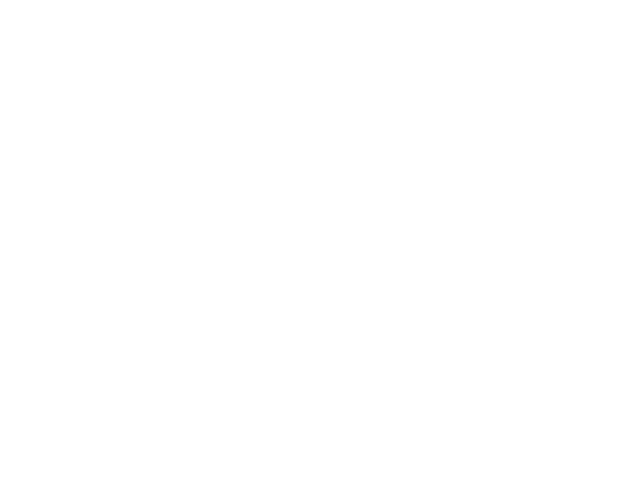

In [118]:
sns.distplot(df_descr_churn['num_years_antig'])
sns.distplot(df_descr_no_churn['num_years_antig'])
plt.savefig("churnAntiquity.png")
plt.clf()

sns.distplot(df_descr_churn['date_end'])
sns.distplot(df_descr_no_churn['date_end'])
plt.savefig("churnContractleft.png")
plt.clf()

sns.distplot(df_descr_churn['date_activ'])
sns.distplot(df_descr_no_churn['date_activ'])
plt.savefig("churnContractAge.png")
plt.clf()

sns.distplot(df_descr_churn['cons_12m'])
#sns.distplot(df_descr_no_churn['cons_12m'])
plt.savefig("churnConsumption.png")
plt.clf()
sns.distplot(df_descr_no_churn['cons_12m'])
plt.savefig("nochurnConsumption.png")
plt.clf()

sns.distplot(df_descr_churn['price_p1_var'])
sns.distplot(df_descr_no_churn['price_p1_var'])
plt.savefig("churnPriceP1.png")
plt.clf()

sns.distplot(df_descr_churn['price_p2_var'])
sns.distplot(df_descr_no_churn['price_p2_var'])
plt.savefig("churnPriceP2.png")
plt.clf()

sns.distplot(df_descr_churn['price_p3_var'])
sns.distplot(df_descr_no_churn['price_p3_var'])
plt.savefig("churnPriceP3.png")
plt.clf()

sns.distplot(df_descr_churn['price_p1_fix'])
sns.distplot(df_descr_no_churn['price_p1_fix'])
plt.savefig("churnPriceP1fix.png")
plt.clf()

In [157]:
#effect of gas also
cnogas = df_descr_churn['has_gas_f'].sum()
cgas = df_descr_churn['has_gas_t'].sum()
ncnogas = df_descr_no_churn['has_gas_f'].sum()
ncgas = df_descr_no_churn['has_gas_t'].sum()
print cnogas
print cgas
print ncnogas
print ncgas

#margin
margin_churn = df_descr_churn['net_margin'].sum()
margin_no_churn = df_descr_no_churn['net_margin'].sum()
print margin_churn, margin_no_churn
print df_descr_churn['net_margin'].mean()
print df_descr_no_churn['net_margin'].mean()
#consumption
print df_descr_churn['cons_12m'].mean()
print df_descr_no_churn['cons_12m'].mean()

1361.0
234.0
11771.0
2730.0
399353.77 3109365.43542
250.378539185
214.42420767
88758.6282132
206468.613406


In [ ]:
#Customer questions
# correlation between subscribed power and consumption
df_descr['pow_max'].describe()
fig = plt.figure()
plt.clf()
plt.scatter(df_descr.pow_max, df_descr.cons_12m)
plt.title("Consumption vs Subscribed power",fontsize=20)
plt.xlabel('subscribed power', fontsize=14)
plt.ylabel('electricity consumption 12 months', fontsize=14)
plt.show()
fig.savefig('ConsumptionPower.png')
plt.clf()

fig=plt.figure()
sns.jointplot(x="pow_max", y="cons_12m",data=df_descr,size=8, alpha=.25,
              color='k', marker='.')
plt.tight_layout()
plt.savefig('ConsumptionPower2.png')

In [104]:
#Customer question
#Link between channel sales and churn
# use pre one hot
joint_train_custq3 = joint[:nrows]
#append ytrain
df_custq3 = pd.merge(joint_train_custq3,ytrain,on='id',how='inner')
#subset train data churn/no churn
df_custq3_churn = df_custq3.loc[df_custq3['churn'] == 1]
df_custq3_no_churn = df_custq3.loc[df_custq3['churn'] == 0]
print df_custq3_churn['channel_sales'].value_counts()
print df_custq3_no_churn['channel_sales'].value_counts()
#sns.countplot(x="channel_sales",data=df_custq3_no_churn,palette="Greens_d")
#plt.savefig("channelSalesNoChurn")
print df_custq3_churn['activity_new'].value_counts()
print df_custq3_no_churn['activity_new'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    922
0                                   325
usilxuppasemubllopkaafesmlibmsdf    150
lmkebamcaaclubfxadlmueccxoimlema    116
ewpakwlliwisiwduibdlfmalxowmwpci     82
Name: channel_sales, dtype: int64
foosdfpfkusacimwkcsosbicdxkicaua    6455
0                                   3893
lmkebamcaaclubfxadlmueccxoimlema    1957
usilxuppasemubllopkaafesmlibmsdf    1294
ewpakwlliwisiwduibdlfmalxowmwpci     884
sddiedcslfslkckwlfkdpoeeailfpeds      12
epumfxlbckeskwekxbiuasklxalciiuu       4
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64
minor                               1331
apdekpcbwosbxepsfxclislboipuxpop      93
kkklcdamwfafdcfwofuscwfwadblfmce      38
fmwdwsxillemwbbwelxsampiuwwpcdcb      32
kwuslieomapmswolewpobpplkaooaaew      30
wxemiwkumpibllwklfbcooafckufkdlm      17
cluecxlameloamldmasudocsbmaoamdw      14
ckfxocssowaeipxueikxcmaxdmcduxsa      13
cwofmuicebbcmiaaxufmfimpowpacobu      12
sxublbwoeuckkocekklxkllcdxxaisop   

<IPython.core.display.Javascript object>


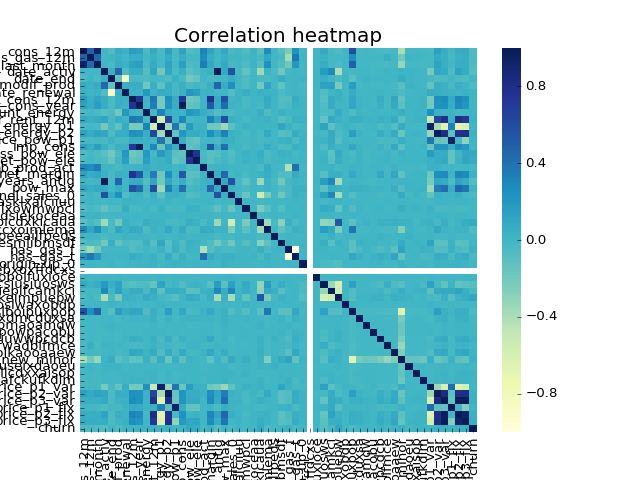

In [36]:
dfcorr = pd.merge(joint_train,ytrain,on='id',how='inner')
dfcorr_use = dfcorr.iloc[:,1:]
#plt.matshow(dfcorr_use.corr())
corr = dfcorr_use.corr()
sns.heatmap(corr, cmap="YlGnBu",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title("Correlation heatmap",fontsize=18)
plt.savefig("Correlation heatmap")

In [120]:
#scale 

joint_train_use = joint_train.iloc[:,1:]
ytrain_use = ytrain.iloc[:,1]
train_x_array = joint_train_use.values
train_y_array = ytrain_use.values
scaler = MinMaxScaler(feature_range=(0,1))
rescaled_train_X_array = scaler.fit_transform(train_x_array)

joint_test_use = joint_test.iloc[:,1:]
test_x_array = joint_test_use.values
rescaled_test_X_array = scaler.fit_transform(test_x_array)

In [121]:
#log reg
logreg = linear_model.LogisticRegression()
logreg.fit(rescaled_train_X_array, train_y_array)
print model.score(lX,y_use_array)
lrpredictions = logreg.predict(rescaled_test_X_array)
lrprob = logreg.predict_proba(rescaled_test_X_array)
print lrprob
print lrprob[:,1].min()
print lrprob[:,1].max()
lrchurn = np.argwhere(lrpredictions > 0)
lrchurn.shape

0.900907057654
[[ 0.67021826  0.32978174]
 [ 0.82532637  0.17467363]
 [ 0.7040175   0.2959825 ]
 ..., 
 [ 0.83104493  0.16895507]
 [ 0.79495644  0.20504356]
 [ 0.87206304  0.12793696]]
0.00451742319217
0.662938830307


(33, 1)

In [122]:
#random forest
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=0)
rf.fit(rescaled_train_X_array, train_y_array)
print rf.oob_score_
print rf.feature_importances_
rfchurn = rf.predict(rescaled_test_X_array)
rfchurnpredict = np.argwhere(rfchurn > 0)
print rfchurnpredict.shape
rfchurnprob  = rf.predict_proba(rescaled_test_X_array)
print rfchurnprob
print rfchurnprob[:,1].min()
print rfchurnprob[:,1].max()

0.906871272366
[  5.93607856e-02   1.30692516e-02   4.23754466e-02   5.50710330e-02
   5.28912933e-02   4.96633193e-02   4.75327969e-02   5.34006725e-02
   3.38731136e-02   4.30770044e-03   5.38848381e-02   3.32368506e-02
   1.90901441e-02   1.05088539e-02   3.47416362e-02   5.23785553e-02
   5.37401326e-02   8.66618954e-03   5.46597536e-02   1.47145108e-02
   4.26675198e-02   4.28733432e-03   0.00000000e+00   2.71942573e-03
   0.00000000e+00   6.82931358e-03   3.17970308e-03   1.96737702e-05
   4.42320454e-03   4.02238693e-03   4.15254936e-03   5.45241992e-04
   0.00000000e+00   1.07197776e-05   4.91021020e-03   4.04893543e-03
   6.86655933e-03   4.54094556e-06   2.42229216e-03   1.08320731e-03
   1.41282175e-03   1.50453630e-03   2.09633823e-03   2.49589704e-03
   1.54483726e-03   5.00310423e-03   7.41360845e-04   1.53250201e-03
   1.94571050e-03   4.54633187e-02   2.42809398e-02   1.76694279e-02
   3.02764142e-02   1.25228791e-02   1.21502161e-02]
(379, 1)
[[ 0.61  0.39]
 [ 0.6   0.

Index([u'cons_12m', u'cons_gas_12m', u'cons_last_month', u'date_activ',
       u'date_end', u'date_modif_prod', u'date_renewal', u'forecast_cons_12m',
       u'forecast_cons_year', u'forecast_discount_energy',
       u'forecast_meter_rent_12m', u'forecast_price_energy_p1',
       u'forecast_price_energy_p2', u'forecast_price_pow_p1', u'imp_cons',
       u'margin_gross_pow_ele', u'margin_net_pow_ele', u'nb_prod_act',
       u'net_margin', u'num_years_antig', u'pow_max', u'channel_sales_0',
       u'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu',
       u'channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci',
       u'channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa',
       u'channel_sales_foosdfpfkusacimwkcsosbicdxkicaua',
       u'channel_sales_lmkebamcaaclubfxadlmueccxoimlema',
       u'channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds',
       u'channel_sales_usilxuppasemubllopkaafesmlibmsdf', u'has_gas_f',
       u'has_gas_t', u'origin_up_0',
       u'origin_up_aabpopmuoobccoxasfsksebxoxffdc

<IPython.core.display.Javascript object>


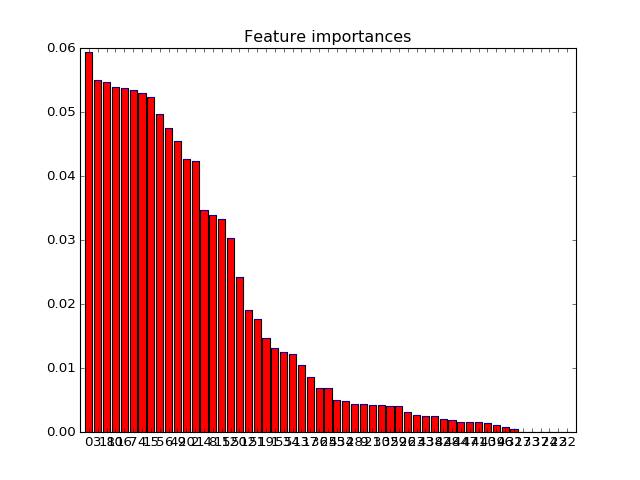

In [125]:
print joint_train_use.columns
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for tree in rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print feature ranking
#for f in range(rescaled_train_X_array.shape[1]):
for f in range(20):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.clf()
plt.title("Feature importances")
plt.bar(range(rescaled_train_X_array.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(rescaled_train_X_array.shape[1]), indices)
plt.xlim([-1, rescaled_train_X_array.shape[1]])
plt.show()
plt.savefig("featureImportance.png")

In [127]:
#xgboost
import xgboost as xgb
gbm = xgb.XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.05).fit(rescaled_train_X_array, train_y_array)
print gbm
gbmTrainaccuracy = accuracy_score(train_y_array, gbm.predict(rescaled_train_X_array))
print gbmTrainaccuracy
gbmpredictions = gbm.predict(rescaled_test_X_array)
gbmchurn = np.argwhere(gbmpredictions > 0)
print gbmchurn.shape
gbmprob = gbm.predict_proba(rescaled_test_X_array)
print gbmprob[:,1].min()
print gbmprob[:,1].max()

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
0.97365805169
(332, 1)
0.00364263
0.923715


In [137]:
print gbmpredictions.shape
print gbmprob.shape
gbmprobchurn = gbmprob[:,1]
predict_prob = np.vstack((gbmpredictions,gbmprobchurn))
tp = predict_prob.T
print tp
print tp.shape
np.savetxt('./ml_case_data/myoutput.csv', tp, fmt='%.4f', delimiter=',')
#read back to sort
myout = pd.read_csv("./ml_case_data/myoutput.csv")
myout.sort_values(myout.columns[2], ascending=False, inplace=True)
myout.to_csv("./ml_case_data/myoutputSorted.csv")

(4024,)
(4024, 2)
[[ 0.          0.46756202]
 [ 0.          0.41531417]
 [ 0.          0.41927493]
 ..., 
 [ 0.          0.22776598]
 [ 0.          0.49964276]
 [ 0.          0.18012172]]
(4024, 2)


In [146]:
myout.shape

(4024, 3)

(4023,)
(4023,)


<IPython.core.display.Javascript object>


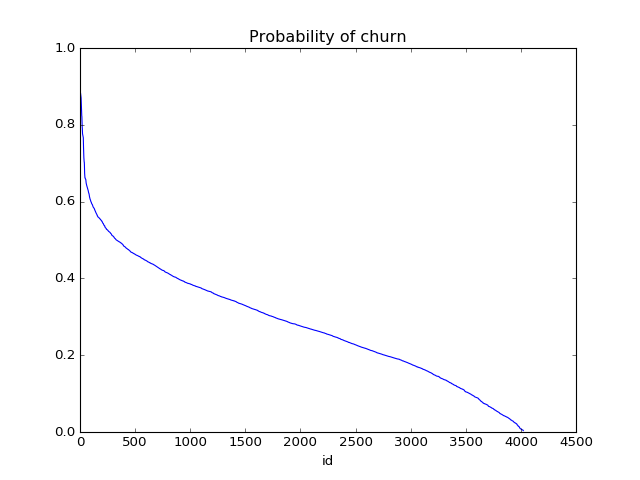

In [155]:
len = myout.shape[0]
xax = np.arange(len-1)
xax = xax.T
print xax.shape
yax = myout.iloc[1:,2]
print yax.shape
plt.plot(xax,yax)
plt.title("Probability of churn")
plt.xlabel("id")
plt.show()
plt.savefig("XGBchurnProb.png")